# Test: train the policy network with trajectories from the optimal policy

Each state transition is (s,a,r,s'), we just **learn to imitate the optimal policy** $\pi^*$ by training with mini-batches and the following cross-entropy loss (on sampled action instead of full distribution):
$$
L(s) = \underset{a \sim \pi^*(s)}{\mathbb{E}}[- \log p_{\theta}(s,a)]
$$
Here we are assuming that the optimal policy can be deterministic or be a mixture of deterministic policies in cases where many actions are equivalently good. The optimal policy we will use assings equal probability to all optimal actions (2 at most), but we will always sample from it and use the action to approximate the expected value.

Another thing that we will keep is the replay buffer, which will be filled with experience from the optimal policy. This is done in order to see if there is any issue with this mechanism.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import copy
# custom imports
import utils
import train
import mcts
from rtfm import featurizer as X
import os

Using device cuda:0
Using device cuda:0


## New replay buffer and policy update

In [2]:
class ActionReplayBuffer:
    def __init__(self, mem_size):
        self.mem_size = mem_size
        self.frame_buffer = []
        self.actions_buffer = []
        self.best_actions_buffer = []
    
    def store_episode(self, frame_lst, actions_lst, best_action_lst):
        frames, actions = self.batch_episode(frame_lst, actions_lst)
        self.frame_buffer.append(frames)
        self.actions_buffer.append(actions)
        self.best_actions_buffer.append(best_action_lst.unsqueeze(0))
        if len(self.frame_buffer) > self.mem_size:
            self.frame_buffer.pop(0)
            self.actions_buffer.pop(0)
            self.best_actions_buffer.pop(0)
            
    def batch_episode(self, frame_lst, actions_lst):
        episode_len = len(actions_lst)
        frames = {}
        for k in frame_lst[0].keys():
            k_value_lst = []
            for b in range(episode_len): # this is a problem, since the frame_lst has one more state!!!
                k_value_lst.append(frame_lst[b][k])
            k_value_lst = torch.cat(k_value_lst, axis=0)
            frames[k] = k_value_lst.unsqueeze(0)
            
        actions = torch.tensor(actions_lst).long() # (T,)
        
        return frames, actions.unsqueeze(0) #(1,T,)
    
    def get_batch(self, batch_size):
        id_range = len(self.actions_buffer)
        assert id_range >= batch_size, "Not enough samples stored to get this batch size"
        sampled_ids = np.random.choice(id_range, size=batch_size, replace=False)
        sampled_actions = torch.cat([self.actions_buffer[i] for i in sampled_ids], axis=0)
        sampled_best_actions = torch.cat([self.best_actions_buffer[i] for i in sampled_ids], axis=0)
        # batch together frames 
        sampled_frames = {}
        for k in self.frame_buffer[0].keys():
            key_values = torch.cat([self.frame_buffer[i][k] for i in sampled_ids], axis=0)
            sampled_frames[k] = key_values
            
        reshaped_frames = {}
        for k in sampled_frames.keys():
            shape = sampled_frames[k].shape
            reshaped_frames[k] = sampled_frames[k].reshape(-1,*shape[2:])
        
        reshaped_actions = sampled_actions.flatten() #(B*T, )
        reshaped_best_actions = sampled_best_actions.reshape(-1, sampled_best_actions.shape[2])
        return reshaped_frames, reshaped_actions, reshaped_best_actions

In [3]:
def compute_policy_update_action_targets(pv_net, frames, target_actions, target_best_actions, optimizer):
    
    target_actions = target_actions.to(device)
    values, probs = pv_net(frames) # (B*T, A)
    # regularize nan, since they won't contribute anyways because the target prob is 0
    probs = torch.clamp(probs, 1e-9, 1 - 1e-9)
    log_probs = torch.log(probs)
  
    loss = F.nll_loss(log_probs, target_actions) # cross-entropy averaged over batch dim
    #print("loss: \n", loss)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    entropy = compute_policy_entropy(probs, log_probs)
    accuracy = compute_policy_accuracy(target_best_actions, probs)
    
    return loss.item(), entropy, accuracy

In [4]:
def compute_policy_entropy(probs, log_probs):
    with torch.no_grad():
        H = -(probs*log_probs).sum(axis=1).mean()
    return H.item()

def compute_policy_accuracy(target_best_actions, probs):
    """
    Notice that in general this is a flawed way of computing the accuracy, because in some cases the 
    target_actions represent just one of the 2 possible optimal actions, thus for those states there is a
    50% chance of choosing the other optimal action and getting a 0 accuracy.
    """
    with torch.no_grad():
        best_actions = probs.argmax(axis=1)
        correct = target_best_actions[torch.arange(len(best_actions)), best_actions]
        accuracy = correct.float().mean().item()
    return accuracy

# Training cycle

In [5]:
# Check only if main logic of the training loop works
ucb_C = 1.0
discount = 0.9 # try with smaller discount
episode_length = 32
max_actions = 5
num_simulations = 100
device = mcts.device
n_episodes = 1000
memory_size = 528
batch_size = 32

training_params = dict(
    ucb_C = ucb_C,
    discount = discount,
    episode_length = episode_length,
    max_actions = max_actions,
    num_simulations = num_simulations,
    device = device,
    n_episodes = n_episodes,
    memory_size = memory_size,
    batch_size = batch_size
)

In [6]:
flags = utils.Flags(env="rtfm:groups_simple_stationary-v0")
gym_env = utils.create_env(flags)
featurizer = X.Render()
game_simulator = mcts.FullTrueSimulator(gym_env, featurizer)
object_ids = utils.get_object_ids_dict(game_simulator)

#pv_net = mcts.FixedDynamicsPVNet(gym_env).to(device)
pv_net = mcts.FixedDynamicsPVNet_v2(gym_env).to(device)
        
optimizer = torch.optim.Adam(pv_net.parameters(), lr=1e-3)
gamma = 10**(-2/(n_episodes-1)) # decrease lr of 2 order of magnitude during training
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma)
rb = ActionReplayBuffer(memory_size)

In [7]:
ID = "opt_policy_AAB"

In [8]:
results = utils.play_episode_optimal_policy_v1(game_simulator, episode_length, object_ids)
total_reward, frame_lst, action_lst, best_action_lst = results

/opt/conda/conda-bld/pytorch_1591914880026/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


Update not executed.
Update not executed.
Update not executed.
Update not executed.
Update not executed.
Update not executed.
Update not executed.
Update not executed.
Update not executed.
Update not executed.
Update not executed.
Update not executed.
Update not executed.
Update not executed.
Update not executed.
Update not executed.
Update not executed.
Update not executed.
Update not executed.
Update not executed.
Update not executed.
Update not executed.
Update not executed.
Update not executed.
Update not executed.
Update not executed.
Update not executed.
Update not executed.
Update not executed.
Update not executed.
Update not executed.
Loss: 2.4727 - Entropy: 1.3910 - Accuracy: 27.7 %
Loss: 2.2705 - Entropy: 1.3679 - Accuracy: 36.0 %
Loss: 2.2330 - Entropy: 1.2964 - Accuracy: 36.4 %
Loss: 2.1681 - Entropy: 1.2876 - Accuracy: 50.4 %
Loss: 2.1673 - Entropy: 1.2658 - Accuracy: 47.2 %
Loss: 2.1778 - Entropy: 1.2719 - Accuracy: 48.8 %
Loss: 2.1537 - Entropy: 1.2559 - Accuracy: 56.2 %

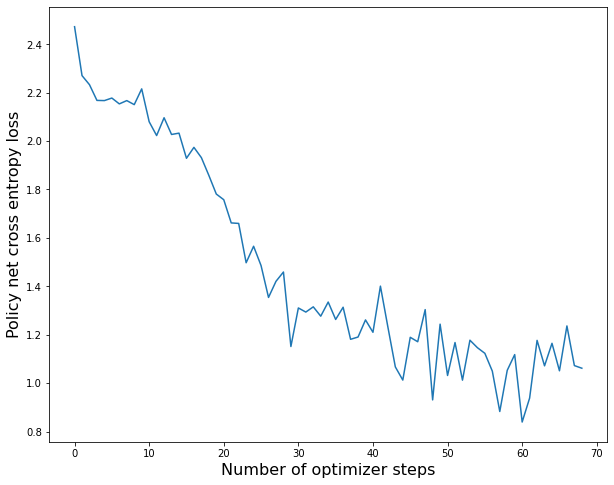

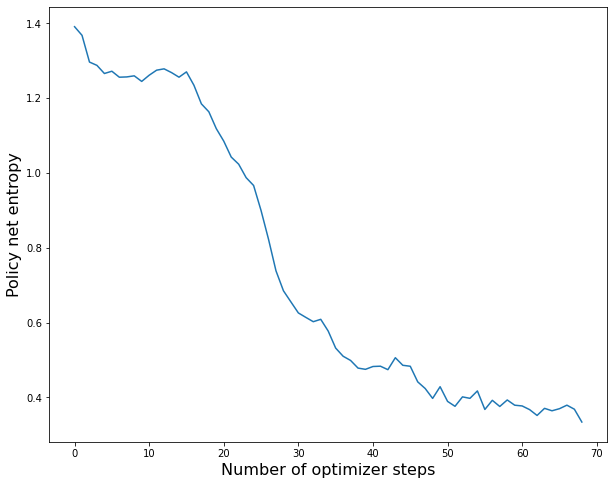

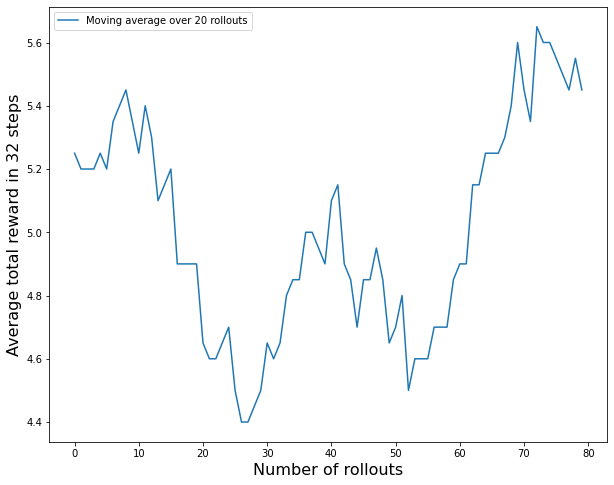

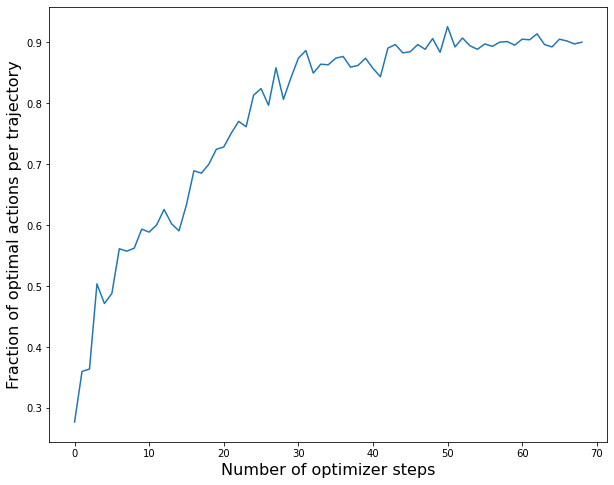

Loss: 0.9657 - Entropy: 0.3594 - Accuracy: 90.3 %
Loss: 1.0382 - Entropy: 0.3621 - Accuracy: 90.2 %
Loss: 0.9704 - Entropy: 0.3240 - Accuracy: 89.9 %
Loss: 1.0119 - Entropy: 0.3391 - Accuracy: 90.7 %
Loss: 1.0613 - Entropy: 0.3556 - Accuracy: 88.4 %
Loss: 0.8641 - Entropy: 0.3157 - Accuracy: 91.9 %
Loss: 1.1249 - Entropy: 0.3390 - Accuracy: 91.5 %
Loss: 0.9381 - Entropy: 0.3582 - Accuracy: 90.1 %
Loss: 1.1695 - Entropy: 0.3536 - Accuracy: 91.0 %
Loss: 0.9686 - Entropy: 0.3595 - Accuracy: 91.3 %
Loss: 1.1286 - Entropy: 0.3420 - Accuracy: 91.2 %
Loss: 0.9469 - Entropy: 0.3374 - Accuracy: 90.6 %
Loss: 0.9838 - Entropy: 0.3221 - Accuracy: 91.1 %
Loss: 1.2257 - Entropy: 0.3403 - Accuracy: 89.3 %
Loss: 0.9689 - Entropy: 0.3176 - Accuracy: 91.4 %
Loss: 1.0807 - Entropy: 0.3340 - Accuracy: 90.8 %
Loss: 1.1728 - Entropy: 0.3177 - Accuracy: 90.5 %
Loss: 1.0091 - Entropy: 0.3305 - Accuracy: 91.3 %
Loss: 1.3095 - Entropy: 0.3348 - Accuracy: 87.0 %
Loss: 0.9804 - Entropy: 0.3222 - Accuracy: 90.8 %


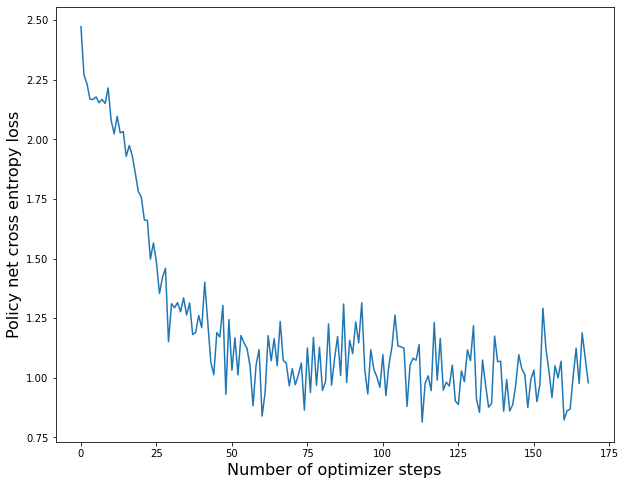

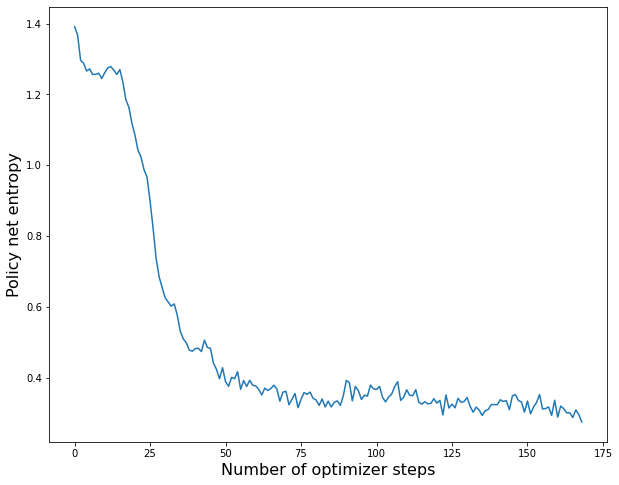

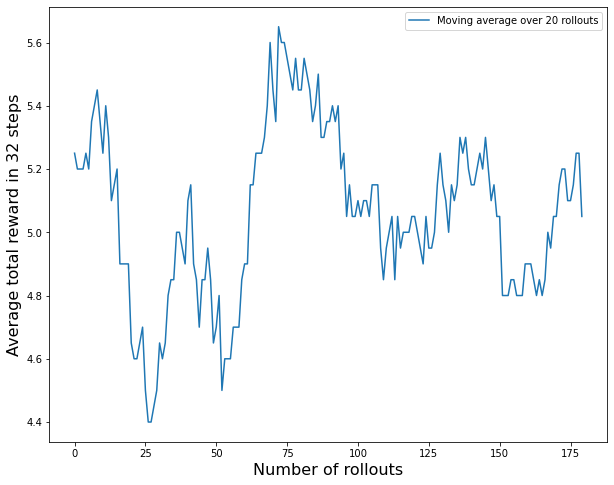

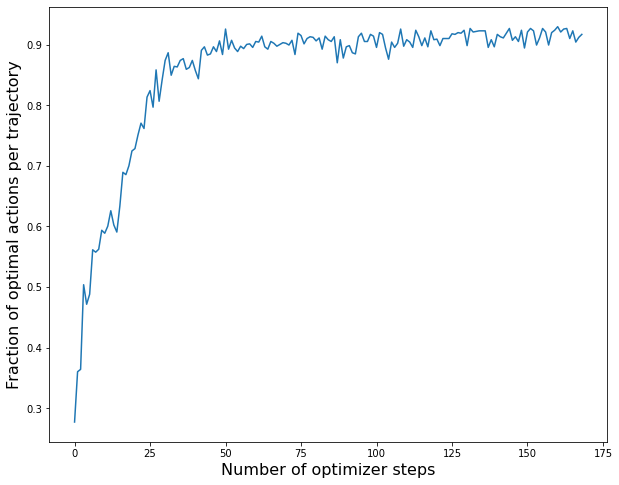

Saved checkpoint.
Loss: 0.9321 - Entropy: 0.2745 - Accuracy: 90.4 %
Loss: 0.9634 - Entropy: 0.3221 - Accuracy: 92.7 %
Loss: 1.0511 - Entropy: 0.3075 - Accuracy: 91.9 %
Loss: 0.9601 - Entropy: 0.3056 - Accuracy: 92.5 %
Loss: 1.2016 - Entropy: 0.3281 - Accuracy: 91.8 %
Loss: 1.2224 - Entropy: 0.2866 - Accuracy: 90.2 %
Loss: 1.0849 - Entropy: 0.3304 - Accuracy: 90.3 %
Loss: 0.9481 - Entropy: 0.3423 - Accuracy: 91.2 %
Loss: 1.1399 - Entropy: 0.3302 - Accuracy: 90.0 %
Loss: 1.1144 - Entropy: 0.3375 - Accuracy: 90.8 %
Loss: 0.9564 - Entropy: 0.3105 - Accuracy: 90.9 %
Loss: 1.0116 - Entropy: 0.3109 - Accuracy: 91.0 %
Loss: 0.9297 - Entropy: 0.3252 - Accuracy: 91.7 %
Loss: 0.9850 - Entropy: 0.2975 - Accuracy: 91.6 %
Loss: 0.9444 - Entropy: 0.3001 - Accuracy: 91.6 %
Loss: 1.1532 - Entropy: 0.3111 - Accuracy: 92.1 %
Loss: 1.1418 - Entropy: 0.3331 - Accuracy: 91.5 %
Loss: 1.0198 - Entropy: 0.3166 - Accuracy: 91.8 %
Loss: 0.9819 - Entropy: 0.3240 - Accuracy: 92.7 %
Loss: 1.0384 - Entropy: 0.3166 -

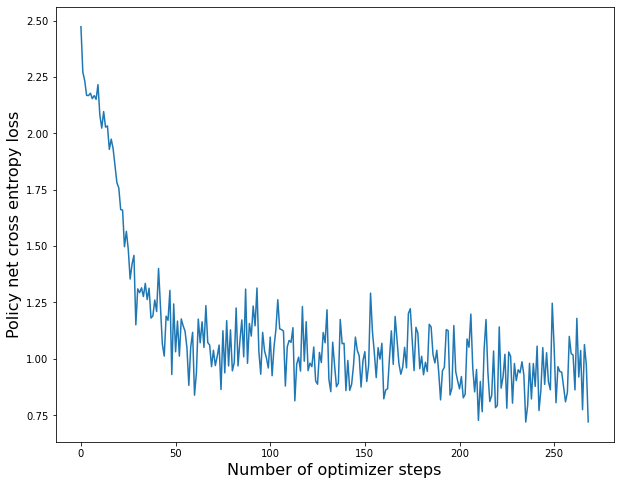

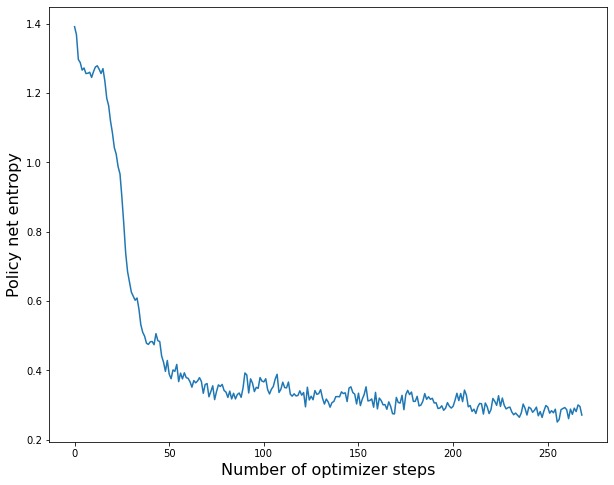

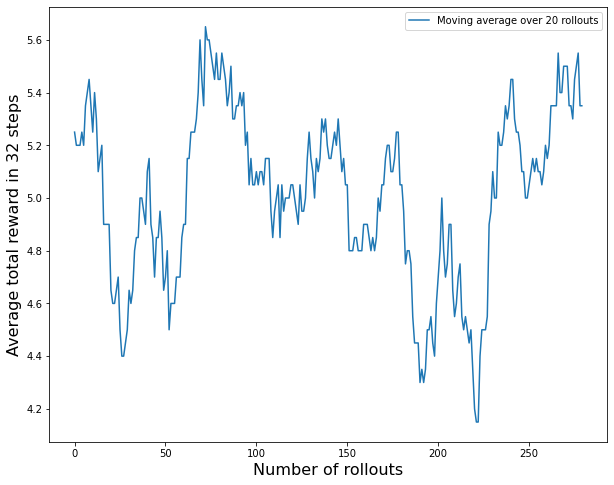

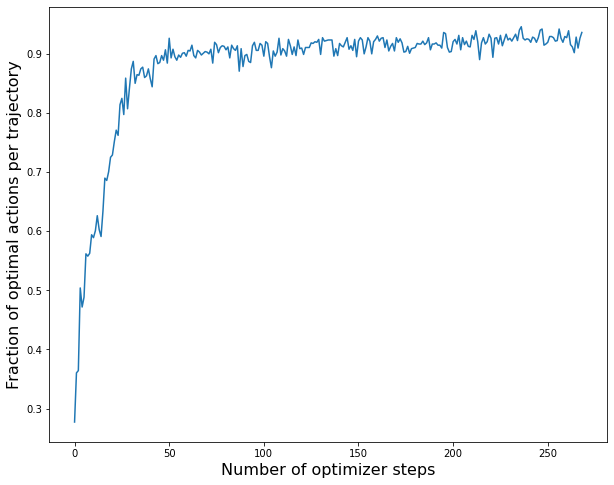

Loss: 0.9898 - Entropy: 0.2961 - Accuracy: 91.8 %
Loss: 0.7644 - Entropy: 0.2975 - Accuracy: 93.2 %
Loss: 1.2223 - Entropy: 0.3166 - Accuracy: 89.0 %
Loss: 1.0849 - Entropy: 0.3241 - Accuracy: 91.4 %
Loss: 0.9540 - Entropy: 0.3097 - Accuracy: 91.7 %
Loss: 0.9210 - Entropy: 0.3256 - Accuracy: 91.1 %
Loss: 1.0972 - Entropy: 0.2828 - Accuracy: 91.4 %
Loss: 0.8811 - Entropy: 0.2852 - Accuracy: 93.5 %
Loss: 1.0604 - Entropy: 0.3037 - Accuracy: 92.1 %
Loss: 1.0818 - Entropy: 0.2765 - Accuracy: 92.3 %
Loss: 0.9875 - Entropy: 0.2771 - Accuracy: 93.1 %
Loss: 0.8231 - Entropy: 0.2828 - Accuracy: 92.7 %
Loss: 0.9075 - Entropy: 0.2676 - Accuracy: 92.2 %
Loss: 1.0222 - Entropy: 0.2799 - Accuracy: 92.7 %
Loss: 1.0302 - Entropy: 0.2748 - Accuracy: 91.5 %
Loss: 0.9203 - Entropy: 0.2808 - Accuracy: 92.7 %
Loss: 0.8969 - Entropy: 0.2746 - Accuracy: 93.4 %
Loss: 0.8459 - Entropy: 0.2686 - Accuracy: 92.7 %
Loss: 0.7894 - Entropy: 0.2761 - Accuracy: 93.5 %
Loss: 0.8114 - Entropy: 0.2718 - Accuracy: 93.6 %


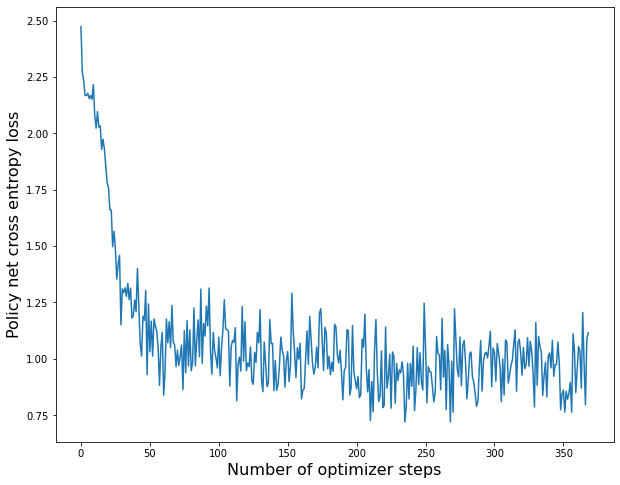

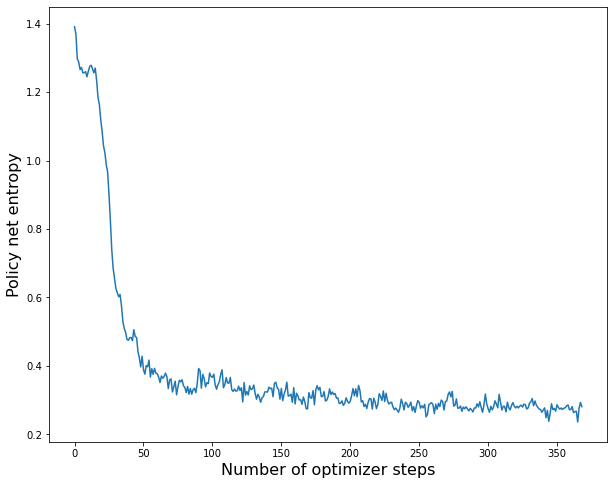

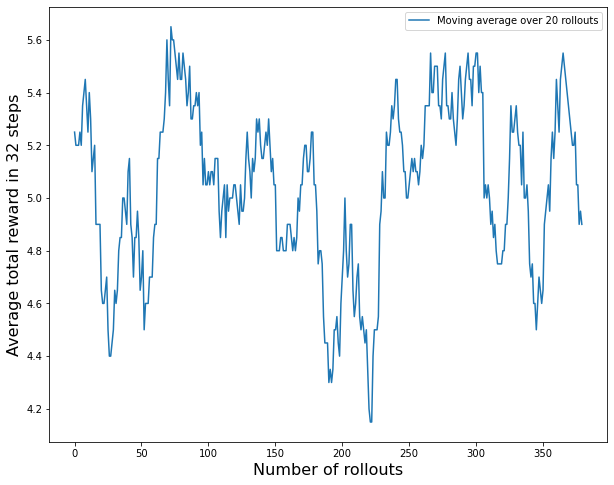

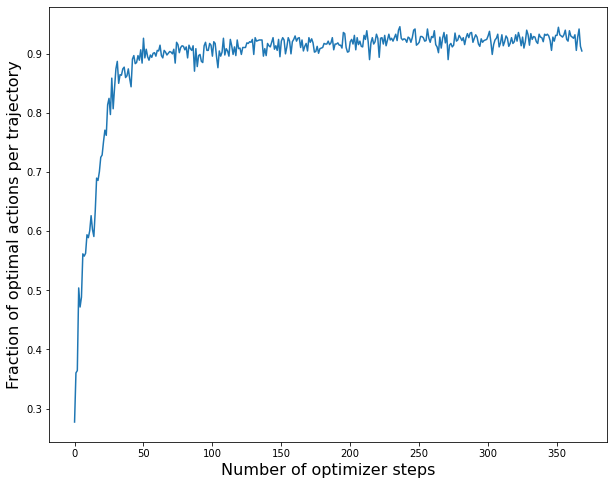

Saved checkpoint.
Loss: 0.8885 - Entropy: 0.2721 - Accuracy: 93.6 %
Loss: 0.7328 - Entropy: 0.2658 - Accuracy: 93.6 %
Loss: 0.9841 - Entropy: 0.2901 - Accuracy: 92.0 %
Loss: 0.8802 - Entropy: 0.2878 - Accuracy: 93.1 %
Loss: 1.0375 - Entropy: 0.2855 - Accuracy: 92.8 %
Loss: 0.9532 - Entropy: 0.2747 - Accuracy: 93.1 %
Loss: 1.1055 - Entropy: 0.3074 - Accuracy: 91.0 %
Loss: 0.9231 - Entropy: 0.2719 - Accuracy: 93.7 %
Loss: 1.0573 - Entropy: 0.2793 - Accuracy: 92.3 %
Loss: 1.1031 - Entropy: 0.3238 - Accuracy: 89.8 %
Loss: 0.8703 - Entropy: 0.2851 - Accuracy: 92.9 %
Loss: 0.8805 - Entropy: 0.2865 - Accuracy: 92.9 %
Loss: 1.0364 - Entropy: 0.2722 - Accuracy: 92.3 %
Loss: 1.0430 - Entropy: 0.2602 - Accuracy: 93.1 %
Loss: 0.9709 - Entropy: 0.2685 - Accuracy: 93.8 %
Loss: 0.9883 - Entropy: 0.2895 - Accuracy: 92.5 %
Loss: 1.1427 - Entropy: 0.2741 - Accuracy: 91.5 %
Loss: 0.7506 - Entropy: 0.2654 - Accuracy: 93.4 %
Loss: 0.8782 - Entropy: 0.2639 - Accuracy: 93.0 %
Loss: 0.6836 - Entropy: 0.2676 -

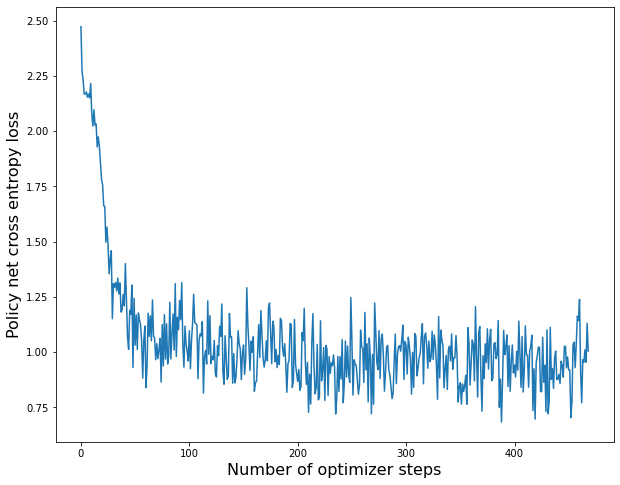

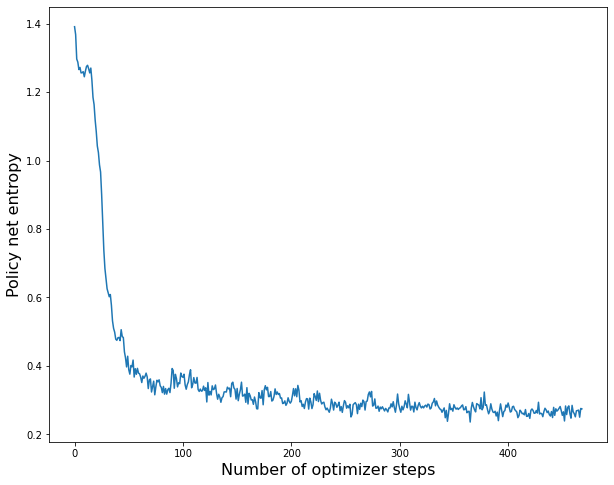

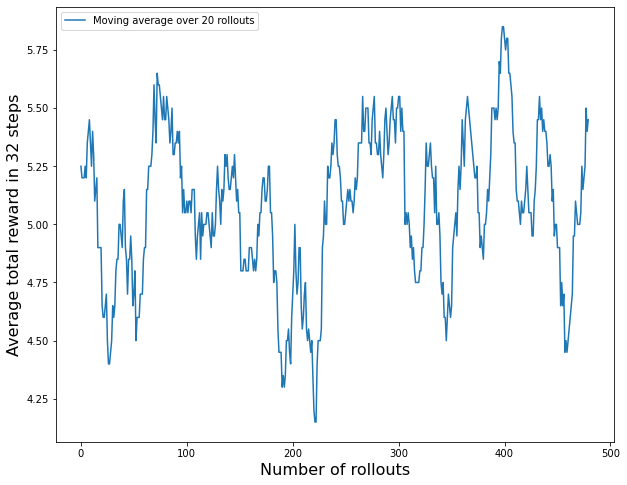

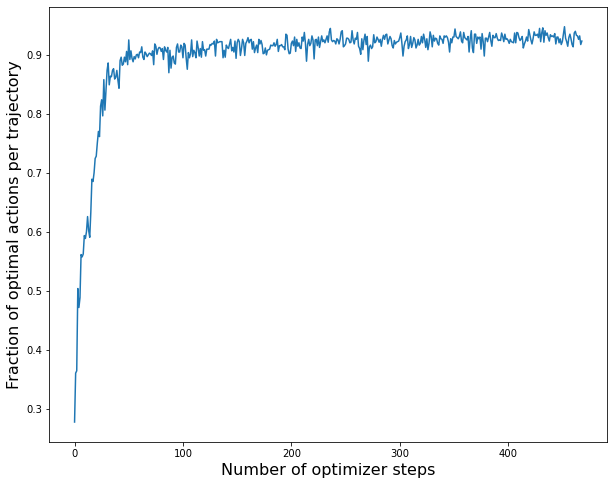

Loss: 0.8406 - Entropy: 0.2532 - Accuracy: 93.8 %
Loss: 1.0111 - Entropy: 0.2661 - Accuracy: 92.6 %
Loss: 0.9176 - Entropy: 0.2598 - Accuracy: 92.5 %
Loss: 0.7801 - Entropy: 0.2611 - Accuracy: 92.9 %
Loss: 1.0112 - Entropy: 0.2784 - Accuracy: 93.3 %
Loss: 1.1427 - Entropy: 0.2680 - Accuracy: 92.0 %
Loss: 0.9651 - Entropy: 0.2367 - Accuracy: 93.2 %
Loss: 0.8470 - Entropy: 0.2498 - Accuracy: 93.8 %
Loss: 0.8356 - Entropy: 0.2644 - Accuracy: 92.9 %
Loss: 0.9179 - Entropy: 0.2573 - Accuracy: 93.6 %
Loss: 1.0019 - Entropy: 0.2677 - Accuracy: 93.6 %
Loss: 1.0386 - Entropy: 0.2581 - Accuracy: 91.9 %
Loss: 0.8430 - Entropy: 0.2525 - Accuracy: 93.4 %
Loss: 0.9013 - Entropy: 0.2679 - Accuracy: 93.3 %
Loss: 0.9245 - Entropy: 0.2554 - Accuracy: 91.7 %
Loss: 0.7558 - Entropy: 0.2514 - Accuracy: 93.8 %
Loss: 0.8394 - Entropy: 0.2611 - Accuracy: 92.9 %
Loss: 1.0401 - Entropy: 0.2748 - Accuracy: 93.3 %
Loss: 0.9922 - Entropy: 0.2528 - Accuracy: 93.2 %
Loss: 0.9323 - Entropy: 0.2672 - Accuracy: 92.8 %


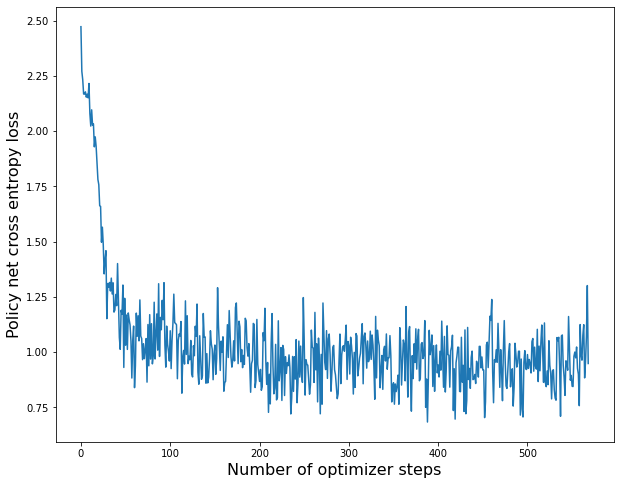

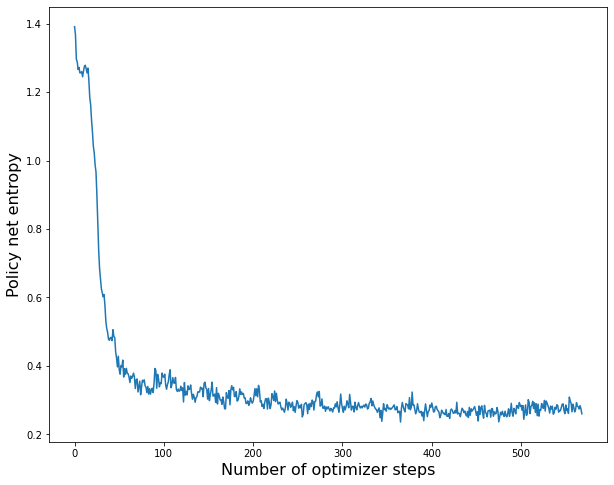

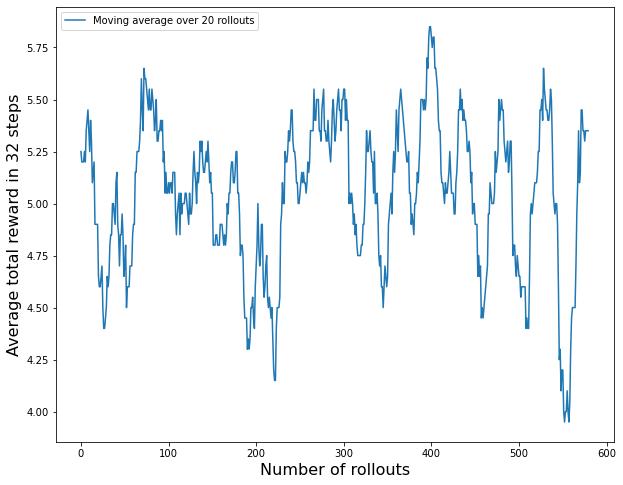

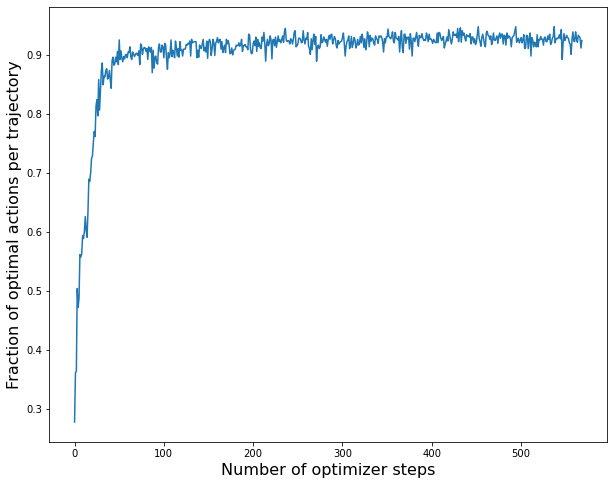

Saved checkpoint.
Loss: 0.8041 - Entropy: 0.2729 - Accuracy: 92.4 %
Loss: 1.0451 - Entropy: 0.3061 - Accuracy: 93.5 %
Loss: 0.9482 - Entropy: 0.2740 - Accuracy: 92.8 %
Loss: 0.8917 - Entropy: 0.2953 - Accuracy: 93.8 %
Loss: 0.9733 - Entropy: 0.2697 - Accuracy: 93.4 %
Loss: 1.0386 - Entropy: 0.2677 - Accuracy: 93.1 %
Loss: 0.8274 - Entropy: 0.2894 - Accuracy: 93.0 %
Loss: 1.0120 - Entropy: 0.2809 - Accuracy: 92.2 %
Loss: 1.0260 - Entropy: 0.2851 - Accuracy: 91.7 %
Loss: 0.9289 - Entropy: 0.2598 - Accuracy: 92.5 %
Loss: 0.9794 - Entropy: 0.2676 - Accuracy: 93.8 %
Loss: 0.9642 - Entropy: 0.2587 - Accuracy: 92.3 %
Loss: 1.0091 - Entropy: 0.2815 - Accuracy: 92.2 %
Loss: 0.9495 - Entropy: 0.2824 - Accuracy: 92.5 %
Loss: 0.6973 - Entropy: 0.2664 - Accuracy: 93.3 %
Loss: 1.0057 - Entropy: 0.2620 - Accuracy: 92.8 %
Loss: 0.7470 - Entropy: 0.2609 - Accuracy: 93.8 %
Loss: 1.0878 - Entropy: 0.2683 - Accuracy: 92.4 %
Loss: 0.8755 - Entropy: 0.2784 - Accuracy: 92.6 %
Loss: 1.0466 - Entropy: 0.2910 -

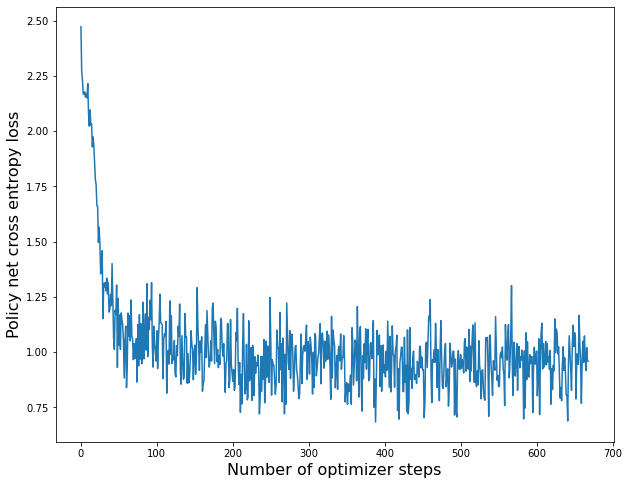

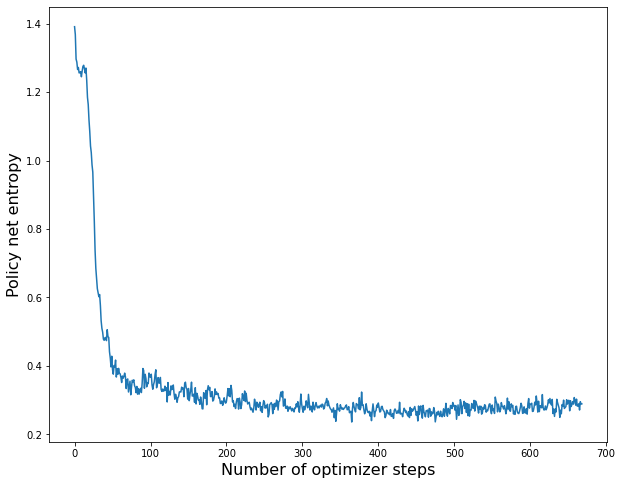

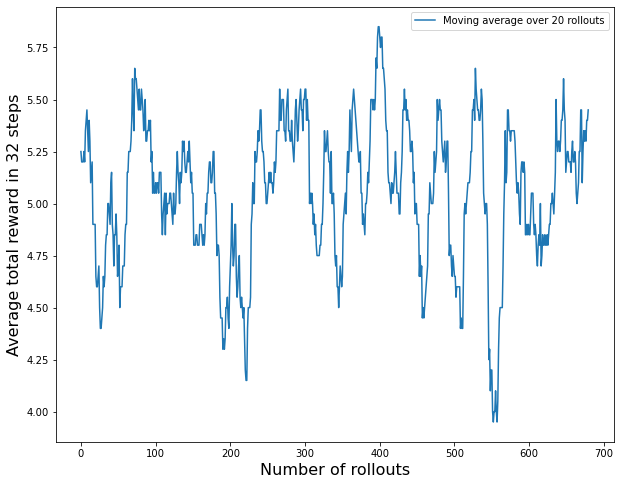

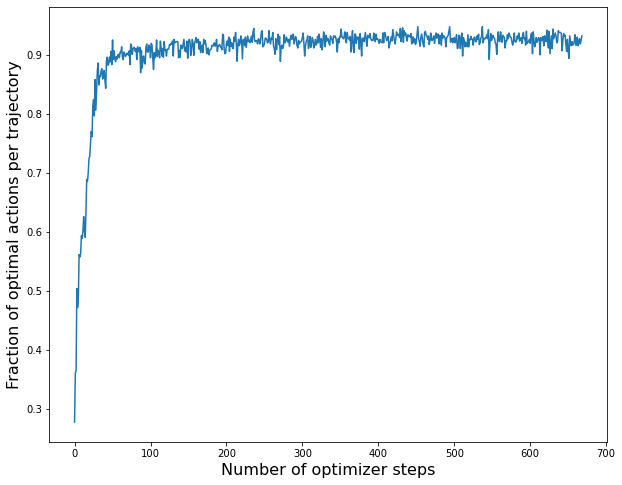

Loss: 1.1553 - Entropy: 0.3000 - Accuracy: 91.7 %
Loss: 1.0405 - Entropy: 0.2720 - Accuracy: 93.7 %
Loss: 0.8550 - Entropy: 0.2671 - Accuracy: 93.0 %
Loss: 1.0096 - Entropy: 0.2782 - Accuracy: 92.3 %
Loss: 0.8337 - Entropy: 0.2987 - Accuracy: 92.8 %
Loss: 1.1027 - Entropy: 0.2960 - Accuracy: 91.2 %
Loss: 1.0683 - Entropy: 0.2786 - Accuracy: 90.7 %
Loss: 1.0123 - Entropy: 0.2933 - Accuracy: 92.4 %
Loss: 1.0574 - Entropy: 0.2641 - Accuracy: 92.9 %
Loss: 0.9372 - Entropy: 0.2751 - Accuracy: 92.8 %
Loss: 0.9873 - Entropy: 0.2838 - Accuracy: 91.9 %
Loss: 0.9411 - Entropy: 0.2835 - Accuracy: 92.7 %
Loss: 0.7668 - Entropy: 0.2788 - Accuracy: 95.2 %
Loss: 0.8850 - Entropy: 0.2734 - Accuracy: 92.3 %
Loss: 1.0202 - Entropy: 0.2920 - Accuracy: 92.3 %
Loss: 0.8984 - Entropy: 0.2813 - Accuracy: 92.7 %
Loss: 1.0518 - Entropy: 0.2803 - Accuracy: 91.6 %
Loss: 1.1841 - Entropy: 0.3049 - Accuracy: 90.6 %
Loss: 1.0133 - Entropy: 0.2963 - Accuracy: 90.8 %
Loss: 0.9252 - Entropy: 0.2991 - Accuracy: 92.0 %


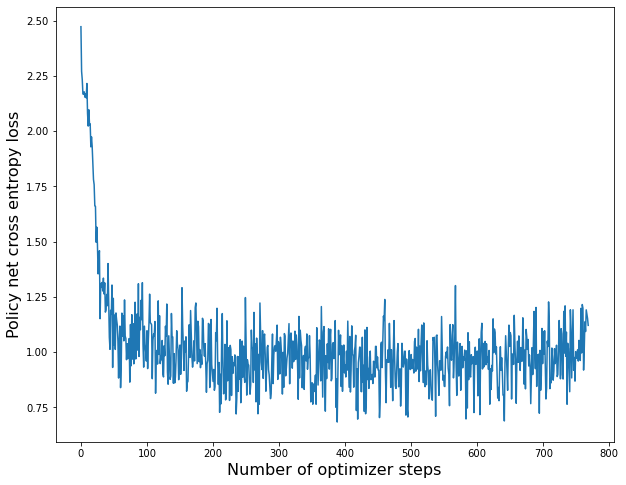

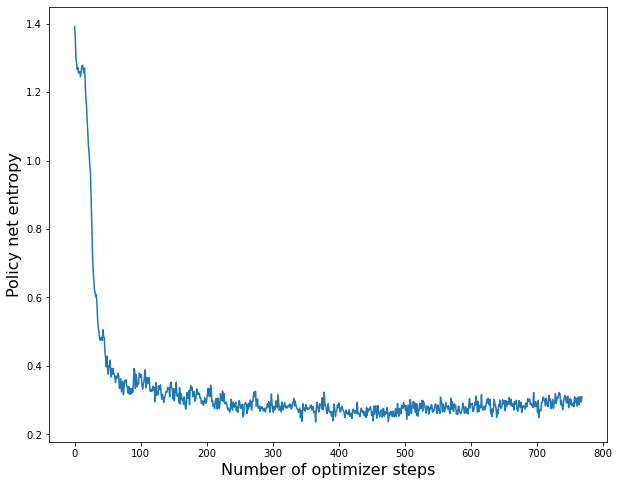

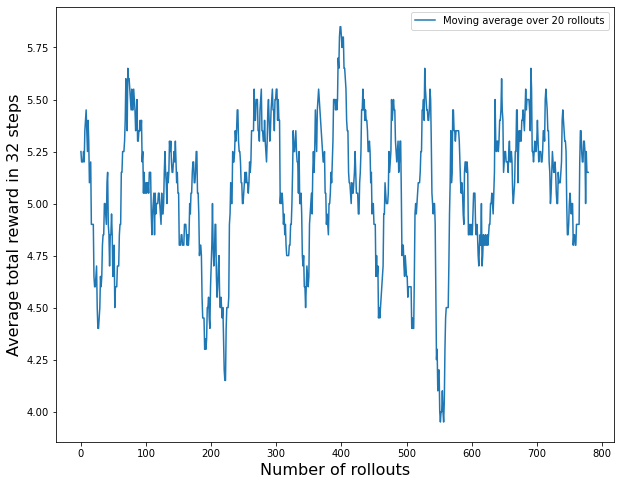

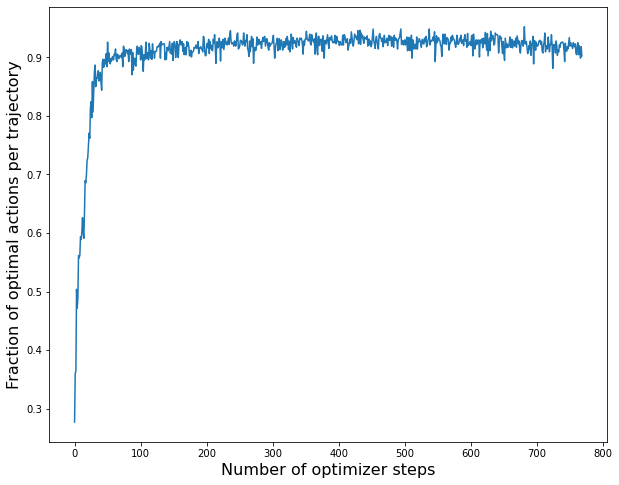

Saved checkpoint.
Loss: 1.1614 - Entropy: 0.3205 - Accuracy: 90.0 %
Loss: 1.2733 - Entropy: 0.3089 - Accuracy: 91.3 %
Loss: 1.0789 - Entropy: 0.3172 - Accuracy: 91.7 %
Loss: 1.0375 - Entropy: 0.2966 - Accuracy: 91.3 %
Loss: 0.7113 - Entropy: 0.2766 - Accuracy: 93.8 %
Loss: 0.8452 - Entropy: 0.2977 - Accuracy: 92.6 %
Loss: 1.1470 - Entropy: 0.3037 - Accuracy: 91.9 %
Loss: 0.9548 - Entropy: 0.2765 - Accuracy: 92.4 %
Loss: 1.1132 - Entropy: 0.2946 - Accuracy: 92.1 %
Loss: 0.9695 - Entropy: 0.2975 - Accuracy: 91.8 %
Loss: 1.1402 - Entropy: 0.3078 - Accuracy: 90.9 %
Loss: 1.0576 - Entropy: 0.3088 - Accuracy: 91.2 %
Loss: 1.2031 - Entropy: 0.3070 - Accuracy: 91.2 %
Loss: 0.9719 - Entropy: 0.3160 - Accuracy: 91.7 %
Loss: 1.1324 - Entropy: 0.3188 - Accuracy: 89.4 %
Loss: 1.0038 - Entropy: 0.2951 - Accuracy: 92.6 %
Loss: 0.9648 - Entropy: 0.3149 - Accuracy: 91.6 %
Loss: 0.8299 - Entropy: 0.3268 - Accuracy: 92.8 %
Loss: 0.9154 - Entropy: 0.2975 - Accuracy: 91.2 %
Loss: 1.0178 - Entropy: 0.2923 -

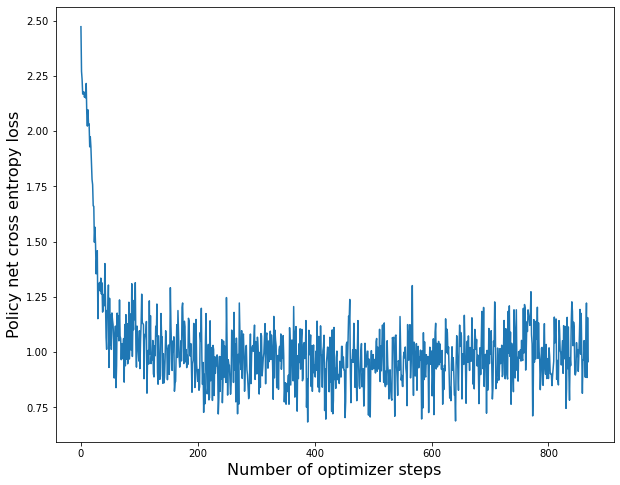

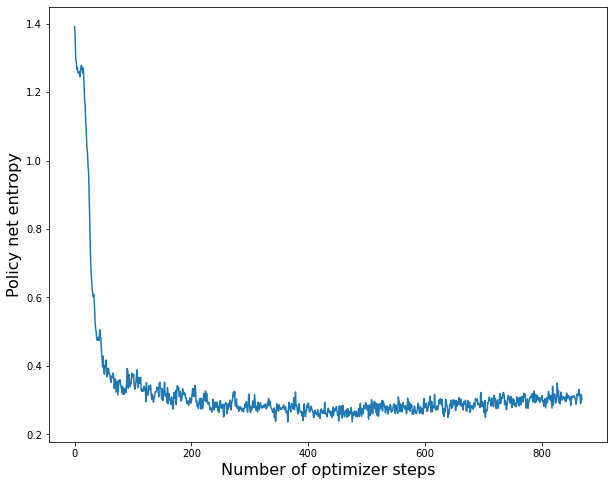

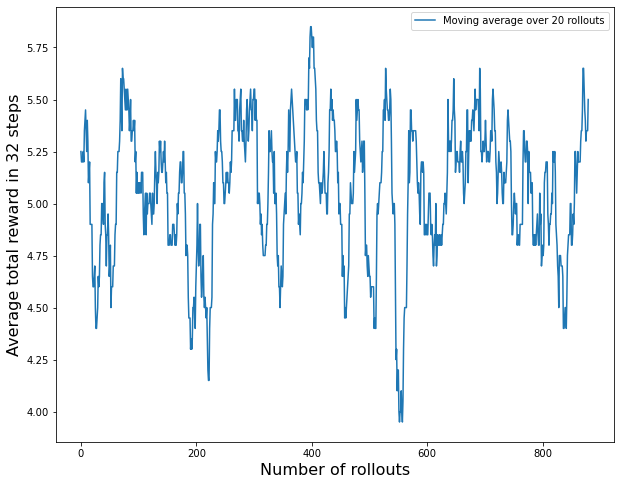

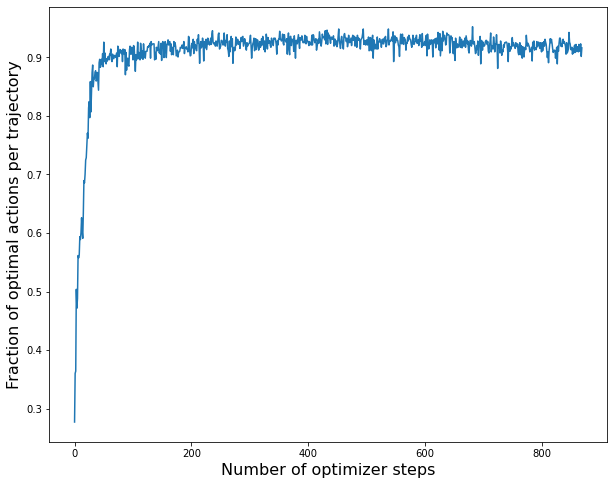

Loss: 0.9990 - Entropy: 0.3130 - Accuracy: 91.7 %
Loss: 1.0312 - Entropy: 0.3185 - Accuracy: 90.1 %
Loss: 1.0053 - Entropy: 0.2962 - Accuracy: 91.9 %
Loss: 0.9312 - Entropy: 0.3232 - Accuracy: 92.6 %
Loss: 0.9174 - Entropy: 0.3207 - Accuracy: 92.0 %
Loss: 0.8128 - Entropy: 0.3131 - Accuracy: 90.9 %
Loss: 0.9248 - Entropy: 0.3160 - Accuracy: 91.6 %
Loss: 0.7015 - Entropy: 0.2904 - Accuracy: 92.1 %
Loss: 0.9988 - Entropy: 0.3161 - Accuracy: 90.4 %
Loss: 0.9463 - Entropy: 0.2911 - Accuracy: 91.3 %
Loss: 0.9958 - Entropy: 0.3050 - Accuracy: 91.9 %
Loss: 1.0129 - Entropy: 0.3102 - Accuracy: 90.7 %
Loss: 1.0815 - Entropy: 0.3092 - Accuracy: 89.7 %
Loss: 1.0950 - Entropy: 0.3042 - Accuracy: 91.4 %
Loss: 1.0307 - Entropy: 0.3065 - Accuracy: 90.4 %
Loss: 1.1414 - Entropy: 0.3122 - Accuracy: 91.2 %
Loss: 0.9872 - Entropy: 0.3210 - Accuracy: 92.7 %
Loss: 0.8251 - Entropy: 0.2987 - Accuracy: 91.7 %
Loss: 0.9900 - Entropy: 0.3014 - Accuracy: 90.6 %
Loss: 1.1039 - Entropy: 0.3119 - Accuracy: 90.8 %


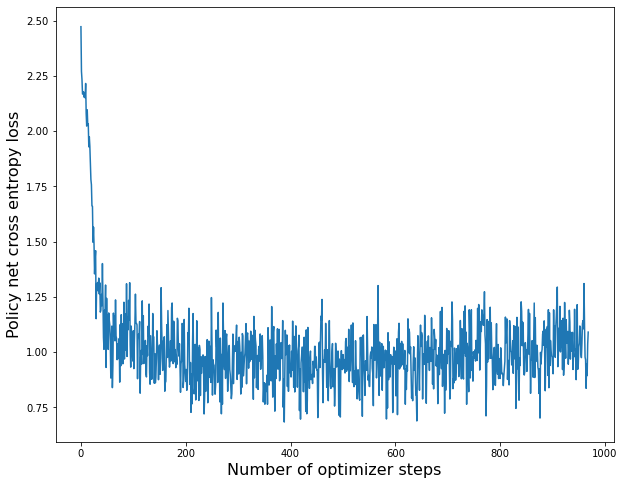

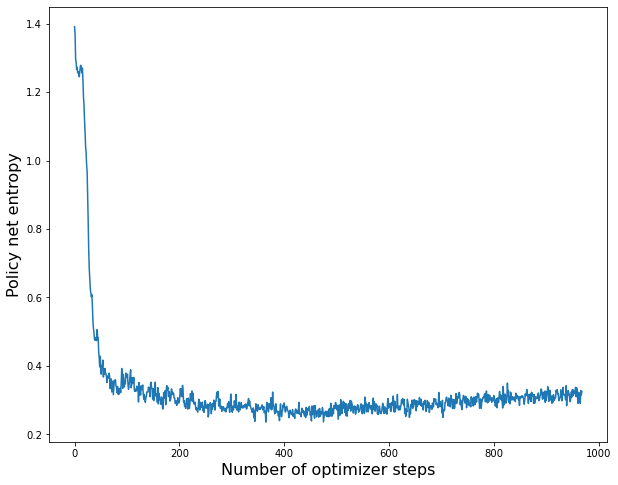

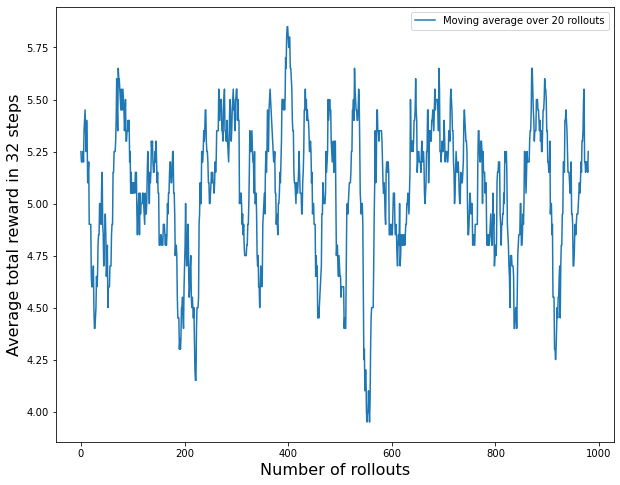

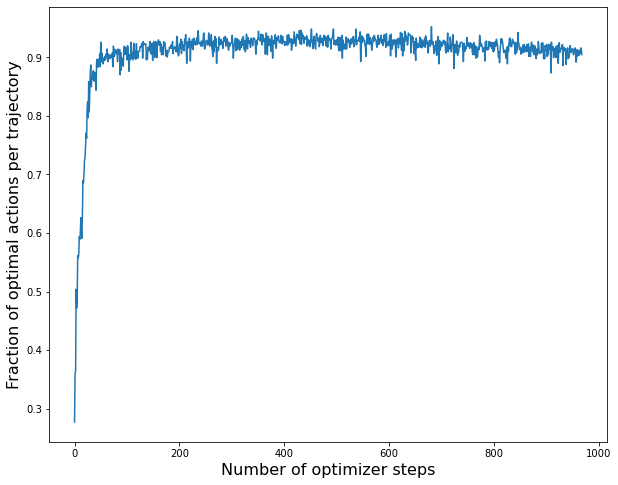

Saved checkpoint.
CPU times: user 1min 5s, sys: 5.54 s, total: 1min 11s
Wall time: 1min 12s


In [9]:
%%time
total_rewards = []
losses = []
entropies = []
accuracies = []
for i in range(n_episodes):
    ### Generate experience ###
    t0 = time.time()
    #modes = ["simulate", "predict", "simulate_and_predict"]
    modes=["simulate"]
    mode = np.random.choice(modes)
    #target_net.eval()
    results = utils.play_episode_optimal_policy_v1(game_simulator, episode_length, object_ids)
    total_reward, frame_lst, action_lst, best_action_lst = results
    t1 = time.time()
    total_rewards.append(total_reward)
    #print("\nEpisode %d - Total reward %d "%(i+1, total_reward))
    rollout_time = (t1-t0)/60
    #print("Rollout time: %.2f"%(rollout_time))
    rb.store_episode(frame_lst, action_lst, best_action_lst)
    
    ### Train pv_net ###

    try:
        frames, actions, best_actions = rb.get_batch(batch_size)
        pv_net.train()
        loss, entropy, accuracy = compute_policy_update_action_targets(pv_net, frames, actions, best_actions, optimizer)
        scheduler.step()
        print("Loss: %.4f - Entropy: %.4f - Accuracy: %.1f %%"%(loss, entropy, accuracy*100))
        losses.append(loss)
        entropies.append(entropy)
        accuracies.append(accuracy)

    except:
        print("Update not executed.")
        pass

    if (i+1)%100==0:
        # Print update
        print("\nAverage reward over last 50 rollouts: %.2f\n"%(np.mean(total_rewards[-50:])))
        print("Percentage of optimal actions: %.1f %%"%(np.mean(accuracies[-50:])*100))
        utils.plot_losses(losses)
        utils.plot_entropies(entropies)
        utils.plot_rewards(total_rewards)
        utils.plot_action_optimality(accuracies)
        
    if (i+1)%200==0:
        # Save checkpoint
        pv_net.eval()
        d = dict(
            episodes_played=i,
            training_params=training_params,
            object_ids=object_ids,
            pv_net=pv_net,
            rb=rb,
            losses=losses,
            total_rewards=total_rewards,
            accuracies=accuracies,
            entropies=entropies
        )

        if not os.path.isdir('./save_dir/'+ID+'/'):
            os.mkdir('./save_dir/'+ID+'/')
        torch.save(d, './save_dir/'+ID+'/training_dict_%d'%(i+1))
        print("Saved checkpoint.")

## Test the trained policy

In [6]:
#training_dict = torch.load("saved/training_dict_n_steps_boot_100simul")
training_dict = torch.load("save_dir/opt_policy_AAB/training_dict_1000")
object_ids = training_dict["object_ids"]
pv_net = training_dict["pv_net"]
pv_net.eval()
#target_net = training_dict["target_net"]
rb = training_dict["rb"]
losses = training_dict["losses"]
entropies = training_dict["entropies"]
accuracies = training_dict["accuracies"]
episodes_played = training_dict["episodes_played"]
training_params = training_dict["training_params"]
total_rewards = training_dict["total_rewards"]

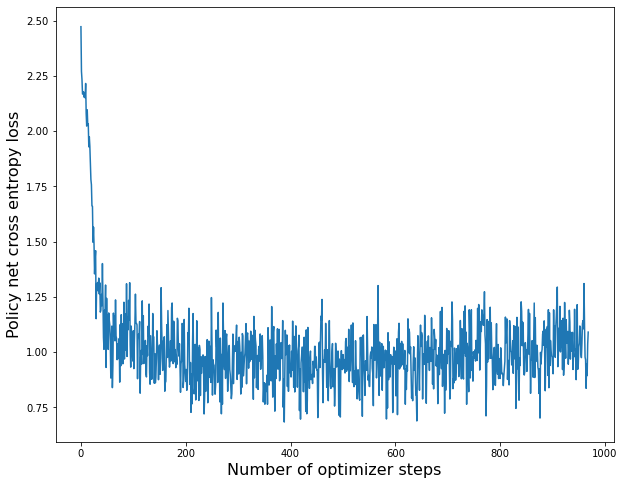

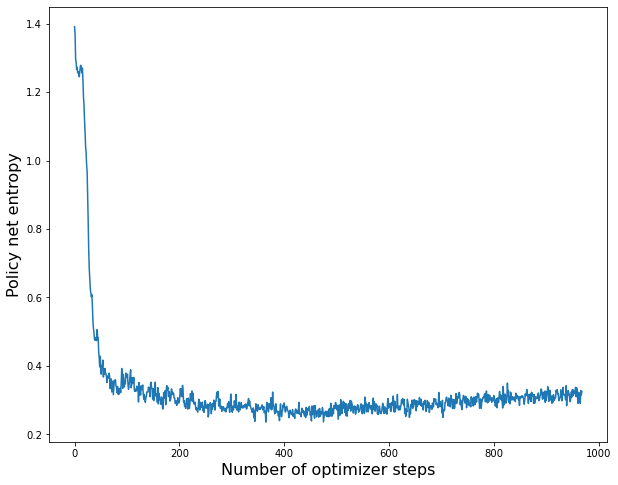

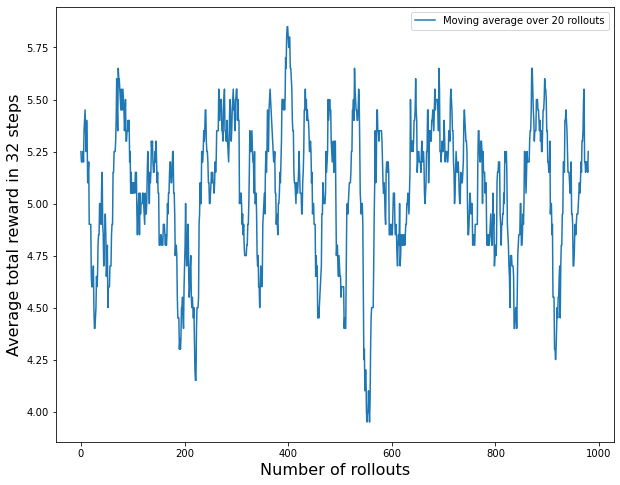

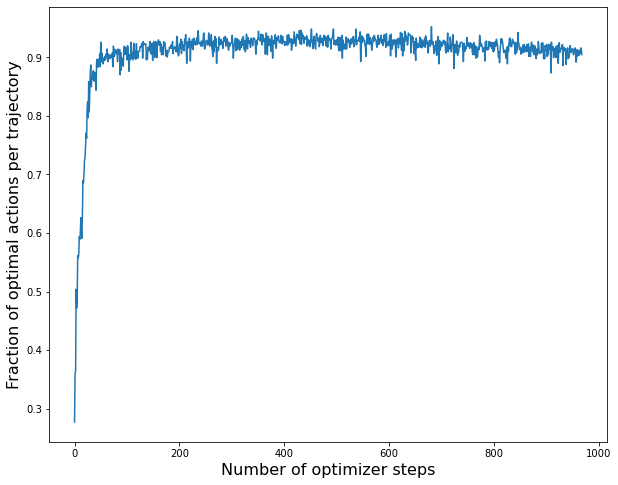

In [7]:
utils.plot_losses(losses)
utils.plot_entropies(entropies)
utils.plot_rewards(total_rewards)
utils.plot_action_optimality(accuracies)

### Policy alone

In [14]:
def play_episode_policy(pv_net, env, episode_length, render=False, argmax=True):
    action_dict = {
        0:"Stay",
        1:"Up",
        2:"Down",
        3:"Left",
        4:"Right"
    }
    frame, valid_actions = env.reset()
    if render:
        env.render()
    total_reward = 0
    done = False
    action_is_optimal = []
    
    for i in range(episode_length):
        with torch.no_grad():
            value, probs = pv_net(frame)
        if not argmax:
            action = torch.multinomial(probs.flatten(), num_samples=1).item()
        else:
            action = torch.argmax(probs.flatten()).item()
        if render:
            print("probs from pv_net: ", probs)
            print("Action sampled from probs: ", action, "({})".format(action_dict[action]))

        # Evaluate chosen action against optimal policy
        best_actions = utils.get_optimal_actions(frame, object_ids)
        if render:
            print("Best actions: ", best_actions, [action_dict[a] for a in best_actions])
        if action in best_actions:
            action_is_optimal.append(True)
        else:
            action_is_optimal.append(False)
            
        frame, valid_actions, reward, done = env.step(action)

        if render:
            env.render()
            print("Reward received: ", reward)
            print("Done: ", done)
        total_reward += reward
        if done:
            break
    return total_reward, action_is_optimal

In [15]:
total_reward, action_is_optimal = play_episode_policy(pv_net, game_simulator, episode_length, render=True)


██████
█? ! █
█ny  █
█@   █
█    █
██████

probs from pv_net:  tensor([[2.3399e-04, 7.7396e-01, 2.9643e-04, 0.0000e+00, 2.2551e-01]],
       device='cuda:0')
Action sampled from probs:  1 (Up)
Best actions:  [4, 1] ['Right', 'Up']

██████
█? ! █
█@y  █
█    █
█    █
██████
gleaming sword
Reward received:  0
Done:  False
probs from pv_net:  tensor([[1.4298e-06, 1.4527e-04, 2.0894e-05, 0.0000e+00, 9.9983e-01]],
       device='cuda:0')
Action sampled from probs:  4 (Right)
Best actions:  [4] ['Right']

██████
█? ! █
█ @  █
█    █
█    █
██████
blessed sword
Reward received:  0
Done:  False
probs from pv_net:  tensor([[1.4975e-04, 4.4210e-01, 2.1597e-05, 2.1766e-05, 5.5771e-01]],
       device='cuda:0')
Action sampled from probs:  4 (Right)
Best actions:  [1, 4] ['Up', 'Right']

██████
█? ! █
█  @ █
█    █
█    █
██████
blessed sword
Reward received:  0
Done:  False
probs from pv_net:  tensor([[3.0909e-05, 9.9972e-01, 3.4749e-07, 1.1152e-05, 2.3870e-04]],
       device='cuda:0')
Action sa

In [16]:
def performance_policy_standalone(pv_net, game_simulator, episode_length, n_episodes):
    rewards = []
    average_perc_optimal_actions = []
    for i in range(n_episodes):
        if i==0:
            render=True
        else:
            render=False
        total_reward, action_is_optimal = play_episode_policy(pv_net, game_simulator, episode_length, render=render)
        rewards.append(total_reward)
        average_perc_optimal_actions.append(np.mean(action_is_optimal))
    print("Percentage of solved episodes: %.1f %%"%(np.mean(rewards)*100))
    print("Percentage of optimal actions: %.1f %%"%(np.mean(average_perc_optimal_actions)*100))
    return rewards, average_perc_optimal_actions

In [17]:
rewards, average_perc_optimal_actions = performance_policy_standalone(pv_net, game_simulator, episode_length, n_episodes=1000)


██████
█yn  █
█   ?█
█ @ !█
█    █
██████

probs from pv_net:  tensor([[6.0035e-04, 1.0491e-01, 7.6784e-04, 8.9337e-01, 3.5379e-04]],
       device='cuda:0')
Action sampled from probs:  3 (Left)
Best actions:  [1, 3] ['Up', 'Left']

██████
█yn  █
█   ?█
█@  !█
█    █
██████

Reward received:  0
Done:  False
probs from pv_net:  tensor([[2.1180e-05, 9.9983e-01, 5.8014e-06, 0.0000e+00, 1.4140e-04]],
       device='cuda:0')
Action sampled from probs:  1 (Up)
Best actions:  [1] ['Up']

██████
█yn  █
█@  ?█
█   !█
█    █
██████

Reward received:  0
Done:  False
probs from pv_net:  tensor([[6.3501e-06, 9.9996e-01, 1.1057e-06, 0.0000e+00, 2.7623e-05]],
       device='cuda:0')
Action sampled from probs:  1 (Up)
Best actions:  [1] ['Up']

██████
█@n  █
█   ?█
█   !█
█    █
██████
blessed sword
Reward received:  0
Done:  False
probs from pv_net:  tensor([[0.0035, 0.0000, 0.9391, 0.0000, 0.0574]], device='cuda:0')
Action sampled from probs:  2 (Down)
Best actions:  [2] ['Down']

██████
█ n  █
█@ 

### MCTS alone

In [18]:
ucb_C = 1.0
discount = 0.9 
episode_length = 32
# redefined for the test, we could try different combinations
max_actions = 20
num_simulations = 50

In [19]:
def play_episode_value_net(
    pv_net,
    env,
    episode_length,
    ucb_C,
    discount,
    max_actions,
    num_simulations,
    object_ids,
    mode="simulate",
    render = False,
    debug_render=False
):
    """
    W.r.t. version 0 it re-uses the information cached in the child node selected 
    """
    action_dict = {
        0:"Stay",
        1:"Up",
        2:"Down",
        3:"Left",
        4:"Right"
    }
    frame, valid_actions = env.reset()
    if render:
        env.render()
    total_reward = 0
    done = False
    new_root = None
    action_is_optimal = []
    for i in range(episode_length):
        tree = mcts.ValueMCTS(
                             frame, 
                             env, 
                             valid_actions, 
                             ucb_C, 
                             discount, 
                             max_actions, 
                             pv_net,
                             render=debug_render, 
                             root=new_root
                             )
        root, info = tree.run(num_simulations, mode=mode)
        action = root.best_action(discount)
        
        # Evaluate chosen action against optimal policy
        best_actions = utils.get_optimal_actions(frame, object_ids)
        if action in best_actions:
            action_is_optimal.append(True)
        else:
            action_is_optimal.append(False)
            
        new_root = tree.get_subtree(action)
        frame, valid_actions, reward, done = env.step(action)
        
        
        if render:
            env.render()
        total_reward += reward
        if done:
            break
    return total_reward, action_is_optimal

In [20]:
def performance_standard_MCTS(pv_net, game_simulator, episode_length, n_episodes):
    rewards = []
    average_perc_optimal_actions = []
    for i in range(n_episodes):
        if i==0:
            render=True
        else:
            render=False
        total_reward, action_is_optimal = play_episode_value_net(
            pv_net, game_simulator, episode_length, ucb_C, discount, max_actions,
            num_simulations, object_ids, mode="simulate", render = render
        )
        
        rewards.append(total_reward)
        average_perc_optimal_actions.append(np.mean(action_is_optimal))
    print("Percentage of solved episodes: %.1f %%"%(np.mean(rewards)*100))
    print("Percentage of optimal actions: %.1f %%"%(np.mean(average_perc_optimal_actions)*100))
    return rewards, average_perc_optimal_actions

In [21]:
%%time
mcts_rewards, mcts_perc_optimal = performance_standard_MCTS(pv_net, game_simulator, episode_length, n_episodes=100)


██████
█  @ █
█ ? !█
█   n█
█   y█
██████


██████
█  @ █
█ ? !█
█   n█
█   y█
██████


██████
█ @  █
█ ? !█
█   n█
█   y█
██████


██████
█@   █
█ ? !█
█   n█
█   y█
██████


██████
█@   █
█ ? !█
█   n█
█   y█
██████


██████
█    █
█@? !█
█   n█
█   y█
██████


██████
█    █
█ ? !█
█@  n█
█   y█
██████


██████
█    █
█ ? !█
█   n█
█@  y█
██████


██████
█    █
█ ? !█
█   n█
█ @ y█
██████


██████
█    █
█ ? !█
█   n█
█ @ y█
██████


██████
█    █
█ ? !█
█   n█
█  @y█
██████


██████
█    █
█ ? !█
█   n█
█  @y█
██████


██████
█    █
█ ? !█
█   n█
█ @ y█
██████


██████
█    █
█ ? !█
█   n█
█  @y█
██████


██████
█    █
█ ? !█
█   n█
█ @ y█
██████


██████
█    █
█ ? !█
█   n█
█@  y█
██████


██████
█    █
█ ? !█
█   n█
█ @ y█
██████


██████
█    █
█ ? !█
█   n█
█  @y█
██████


██████
█    █
█ ? !█
█   n█
█  @y█
██████


██████
█    █
█ ? !█
█   n█
█  @y█
██████


██████
█    █
█ ? !█
█   n█
█  @y█
██████


██████
█    █
█ ? !█
█   n█
█   @█
██████
blessed sword

██████
█    █
█ ? 

### Policy MCTS

In [22]:
temperature = 0.1 # low temperature for more deterministic choices

In [23]:
def performance_policy_MCTS(pv_net, game_simulator, episode_length, n_episodes):
    rewards = []
    average_perc_optimal_actions = []
    for i in range(n_episodes):
        if i==0:
            render=True
        else:
            render=False
            
        results = train.play_episode_policy_value_net(
            pv_net, game_simulator, episode_length, ucb_C, discount, max_actions,
            num_simulations, temperature, object_ids, mode="simulate", render = render
        )
        
        total_reward, frame_lst, reward_lst, done_lst, probs_lst, action_is_optimal = results
        rewards.append(total_reward)
        average_perc_optimal_actions.append(np.mean(action_is_optimal))
    print("Percentage of solved episodes: %.1f %%"%(np.mean(rewards)*100))
    print("Percentage of optimal actions: %.1f %%"%(np.mean(average_perc_optimal_actions)*100))
    return rewards, average_perc_optimal_actions

In [24]:
%%time
pimcts_rewards, pimcts_perc_optimal = performance_policy_MCTS(pv_net, game_simulator, episode_length, n_episodes=100)


██████
█n?  █
█    █
█ ! y█
█  @ █
██████

probs from MCTS:  [0.00000000e+00 1.25325429e-17 0.00000000e+00 0.00000000e+00
 1.00000000e+00]
Action selected from MCTS:  4 (Right)
Best actions:  [1, 4] ['Up', 'Right']

██████
█n?  █
█    █
█ ! y█
█   @█
██████

Reward received:  0
Done:  False
probs from MCTS:  [1.35607171e-20 1.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
Action selected from MCTS:  1 (Up)
Best actions:  [1] ['Up']

██████
█n?  █
█    █
█ ! @█
█    █
██████
blessed sword
Reward received:  0
Done:  False
probs from MCTS:  [0. 0. 0. 1. 0.]
Action selected from MCTS:  3 (Left)
Best actions:  [3] ['Left']

██████
█n?  █
█    █
█ !@ █
█    █
██████
blessed sword
Reward received:  0
Done:  False
probs from MCTS:  [1.32428878e-23 0.00000000e+00 0.00000000e+00 1.00000000e+00
 0.00000000e+00]
Action selected from MCTS:  3 (Left)
Best actions:  [3] ['Left']

██████
█n?  █
█    █
█ @  █
█    █
██████
blessed sword
Reward received:  1
Done:  True
Percentage of solved

# Results

## 1. FixedDynamicsPVNet with lr from $10^{-3}$ to $10^{-5}$ in 2000 steps 

### Policy stand-alone
Percentage of solved episodes: 89.7 % <br>
Percentage of optimal actions: 94.4 %

### MCTS
Percentage of solved episodes: 76.0 % <br>
Percentage of optimal actions: 70.8 %

### Policy MCTS
Percentage of solved episodes: 97.0 % <br>
Percentage of optimal actions: 98.4 %

## 2. FixedDynamicsPVNet_v2 with lr from $10^{-3}$ to $10^{-5}$ in 1000 steps 

### Policy stand-alone
Percentage of solved episodes: 93.1 % <br>
Percentage of optimal actions: 95.8 %

### MCTS (there should be no difference with previous evaluation)
Percentage of solved episodes: 80.0 % <br>
Percentage of optimal actions: 76.2 %

### Policy MCTS
Percentage of solved episodes: 97.0 % <br>
Percentage of optimal actions: 97.1 %

## 3. Optimal policy itself
Percentage of solved episodes: 97.2 % <br>
Percentage of optimal actions: 100 % (by definition)


### Comment
1. Although there are some fluctuations in the percentage of solved games for the various cases, it's quite clear that with both architectures the policy-MCTS has a performance comparable with the optimal policy. 
2. There are some unsolvable configurations of the game, which make the expected percentage of solvable games around 97% instead of 100%. Some configurations of the sort are when the agent is separated from the items by being confined in a corner from the 2 monsters (or the yes item is in the corner with the two monsters around it) or it can also happen that both the yes and the no item are "placed" directly on the agent's inventory and only the no item remains there (I didn't code that myself, so I was quite puzzled by the fact that that condition is considered a valid I.C.)
